## **Klasifikasi Penipuan Transaksi E-Wallet Menggunakan Algoritma Random Forest dengan optimasi RandommizedSearchcv dan teknik Smoteen**


In [ ]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from imblearn.combine import SMOTEENN
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/PMD/dataset/Online_payment_fraud_datections.csv')

# **Preprosesing & EDA**

In [ ]:
# Sampling data untuk mempercepat proses
df = df.sample(n=500_000, random_state=42)

In [ ]:
# === Preprocessing & EDA ===
# Informasi dataset
print("Informasi Dataset:")
print(df.info())

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 781974 to 220455
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            500000 non-null  int64  
 1   type            500000 non-null  object 
 2   amount          500000 non-null  float64
 3   nameOrig        500000 non-null  object 
 4   oldbalanceOrg   500000 non-null  float64
 5   newbalanceOrig  500000 non-null  float64
 6   nameDest        500000 non-null  object 
 7   oldbalanceDest  500000 non-null  float64
 8   newbalanceDest  500000 non-null  float64
 9   isFraud         500000 non-null  int64  
 10  isFlaggedFraud  500000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 45.8+ MB
None


In [ ]:
# Statistik deskriptif
print("\nStatistik Deskriptif:")
print(df.describe())



Statistik Deskriptif:
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  500000.00000  5.000000e+05   5.000000e+05    5.000000e+05   
mean       26.99138  1.587186e+05   8.687144e+05    8.886519e+05   
std        15.65220  2.640532e+05   2.950314e+06    2.986575e+06   
min         1.00000  2.000000e-01   0.000000e+00    0.000000e+00   
25%        15.00000  1.213730e+04   0.000000e+00    0.000000e+00   
50%        20.00000  7.631399e+04   1.607561e+04    0.000000e+00   
75%        39.00000  2.136446e+05   1.375179e+05    1.761684e+05   
max        95.00000  1.000000e+07   3.840000e+07    3.840000e+07   

       oldbalanceDest  newbalanceDest        isFraud  isFlaggedFraud  
count    5.000000e+05    5.000000e+05  500000.000000        500000.0  
mean     9.782757e+05    1.113636e+06       0.001034             0.0  
std      2.304935e+06    2.423811e+06       0.032139             0.0  
min      0.000000e+00    0.000000e+00       0.000000             0.0  
25%      

In [ ]:
# Cek missing values
print("\nCek Missing Values:")
print(df.isnull().sum())


Cek Missing Values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [ ]:
# Distribusi target
print("\nDistribusi Kelas Target (isFraud):")
print(df['isFraud'].value_counts(normalize=True))


Distribusi Kelas Target (isFraud):
isFraud
0    0.998966
1    0.001034
Name: proportion, dtype: float64


In [ ]:
# Hapus kolom yang tidak relevan
df = df.drop(['nameOrig', 'nameDest'], axis=1, errors='ignore')

In [ ]:
# Encoding variabel kategorikal
if 'type' in df.columns:
    df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [ ]:
# Pisahkan fitur (X) dan target (y)
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [ ]:
# Normalisasi data numerik
scaler = StandardScaler()
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
X[num_cols] = scaler.fit_transform(X[num_cols])

In [ ]:
# Split data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

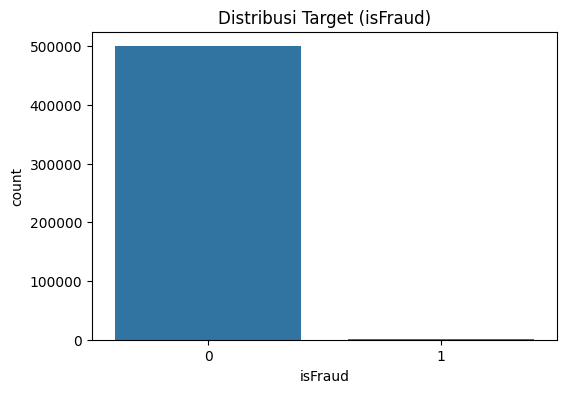

In [ ]:
# Visualisasi distribusi target
plt.figure(figsize=(6, 4))
sns.countplot(x='isFraud', data=df)
plt.title('Distribusi Target (isFraud)')
plt.show()

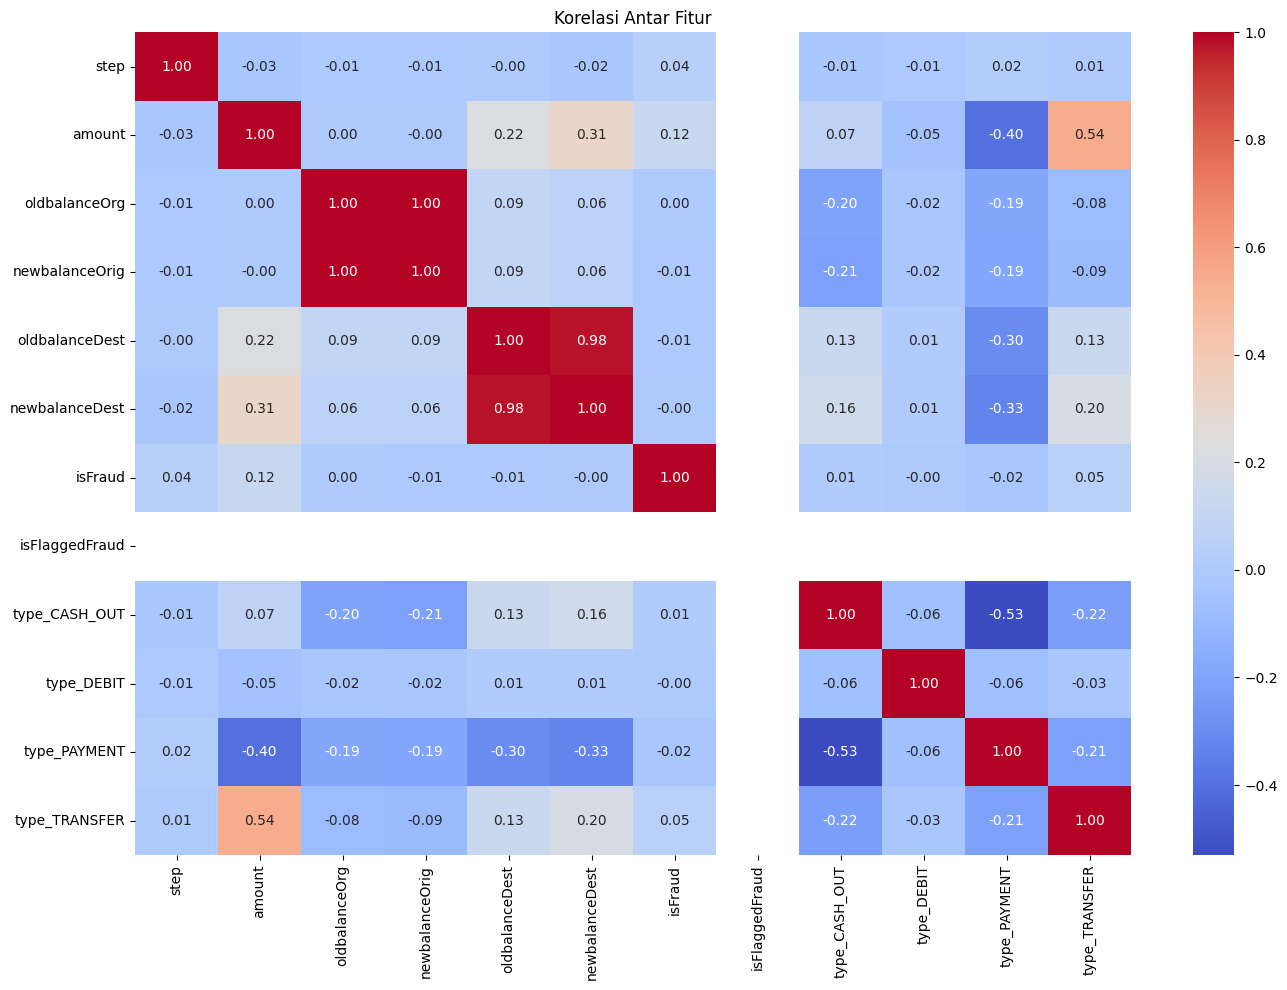

In [ ]:
# Visualisasi korelasi antar fitur
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korelasi Antar Fitur')
plt.tight_layout()
plt.show()

# **Feature Selection**

In [ ]:
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train, y_train)
selector = SelectFromModel(rf_selector, threshold=0.02, prefit=True)


In [ ]:
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
selected_features = X.columns[selector.get_support()]
print(f"\nJumlah fitur terpilih: {X_train_selected.shape[1]}")
print("Fitur Terpilih:", list(selected_features))


Jumlah fitur terpilih: 7
Fitur Terpilih: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'type_TRANSFER']


# **Feature Extraction (PCA)**

In [ ]:
# (PCA)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)
print("Jumlah Komponen PCA:", pca.n_components_)

Jumlah Komponen PCA: 4


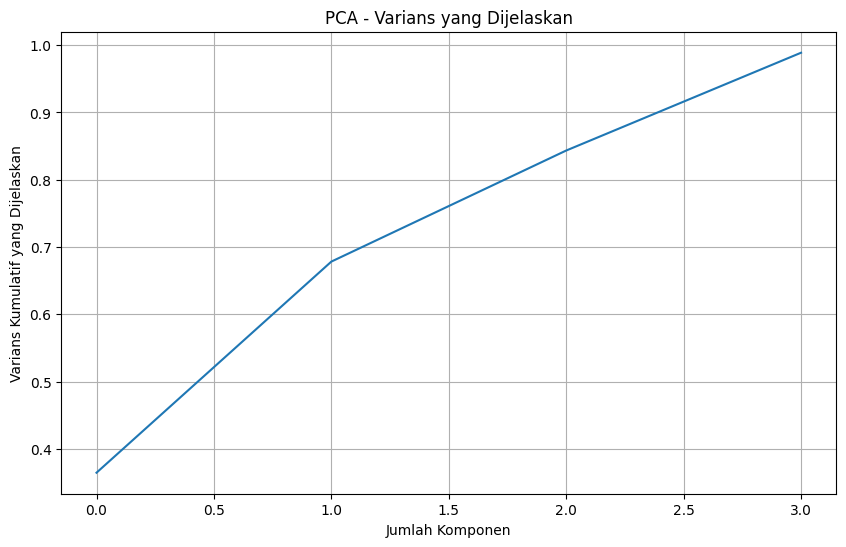

In [ ]:
# Visualisasi PCA
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Jumlah Komponen')
plt.ylabel('Varians Kumulatif yang Dijelaskan')
plt.title('PCA - Varians yang Dijelaskan')
plt.grid()
plt.show()

# **SMOTEEN**

In [ ]:
smoteenn = SMOTEENN(random_state=42)
X_train_balanced, y_train_balanced = smoteenn.fit_resample(X_train_pca, y_train)

In [ ]:
print("\nDistribusi Kelas Target Setelah SMOTEENN:")
print(pd.Series(y_train_balanced).value_counts(normalize=True))


Distribusi Kelas Target Setelah SMOTEENN:
isFraud
1    0.501538
0    0.498462
Name: proportion, dtype: float64


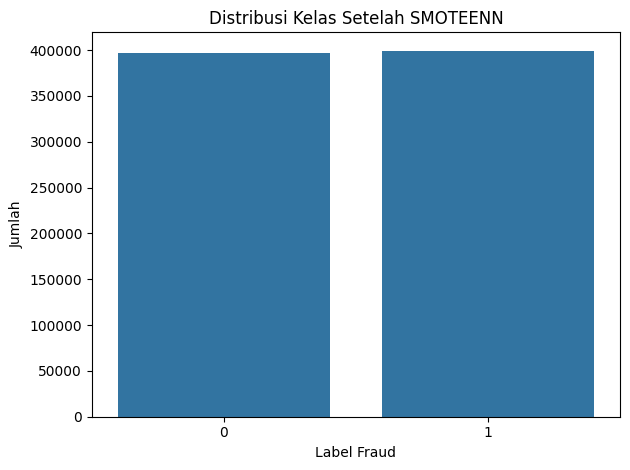

In [ ]:
# Visualisasi distribusi kelas setelah SMOTEENN
sns.countplot(x=y_train_balanced)
plt.title("Distribusi Kelas Setelah SMOTEENN")
plt.xlabel('Label Fraud')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

# **Modeling**

In [ ]:
# === Model Random Forest Awal ===
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train_balanced, y_train_balanced)
y_pred_rf = rf_model.predict(X_test_pca)
print("\n=== Evaluasi Random Forest Awal ===")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, rf_model.predict_proba(X_test_pca)[:, 1]))


=== Evaluasi Random Forest Awal ===
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     99875
           1       0.02      0.74      0.04       125

    accuracy                           0.96    100000
   macro avg       0.51      0.85      0.51    100000
weighted avg       1.00      0.96      0.98    100000

ROC AUC Score: 0.9326131664580726


# **Hypertuning**

In [ ]:
# === Hyperparameter Tuning dengan RandomizedSearchCV ===
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=5,
    scoring='f1',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_balanced, y_train_balanced)
best_rf = random_search.best_estimator_
print("\nBest Parameters dari RandomizedSearchCV:")
print(random_search.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best Parameters dari RandomizedSearchCV:
{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': None, 'class_weight': 'balanced'}


In [ ]:
# Lakukan cross-validation pada model terbaik
cv_scores = cross_val_score(best_rf, X_train_balanced, y_train_balanced, cv=5, scoring='f1', n_jobs=-1)

print("\n=== Hasil Cross-Validation (F1 Score) ===")
print("Skor CV:", cv_scores)
print("Rata-rata Skor CV:", cv_scores.mean())
print("Standar Deviasi Skor CV:", cv_scores.std())


=== Hasil Cross-Validation (F1 Score) ===
Skor CV: [0.99871132 0.99867357 0.99881124 0.99859874 0.99861142]
Rata-rata Skor CV: 0.9986812595666177
Standar Deviasi Skor CV: 7.686839675724381e-05


# **Evaluasi model**

In [ ]:
# Evaluasi model setelah tuning
y_pred_tuned = best_rf.predict(X_test_pca)
print("\n=== Evaluasi Random Forest Setelah Tuning ===")
print(classification_report(y_test, y_pred_tuned))
print("ROC AUC Score:", roc_auc_score(y_test, best_rf.predict_proba(X_test_pca)[:, 1]))


=== Evaluasi Random Forest Setelah Tuning ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99875
           1       0.15      0.66      0.25       125

    accuracy                           0.99    100000
   macro avg       0.58      0.83      0.62    100000
weighted avg       1.00      0.99      1.00    100000

ROC AUC Score: 0.9295349586983728


In [ ]:
# === Analisis Kesalahan ===
conf_matrix = confusion_matrix(y_test, y_pred_tuned)
print("\nConfusion Matrix:")
print(conf_matrix)

false_positives = X_test[(y_test == 0) & (y_pred_tuned == 1)]
false_negatives = X_test[(y_test == 1) & (y_pred_tuned == 0)]
print(f"\nJumlah False Positives: {len(false_positives)}")
print(f"Jumlah False Negatives: {len(false_negatives)}")



Confusion Matrix:
[[99412   463]
 [   42    83]]

Jumlah False Positives: 463
Jumlah False Negatives: 42


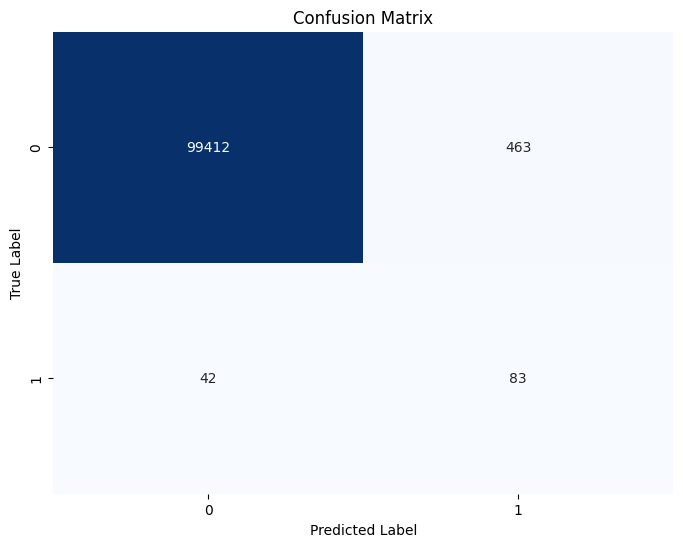

In [ ]:
# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

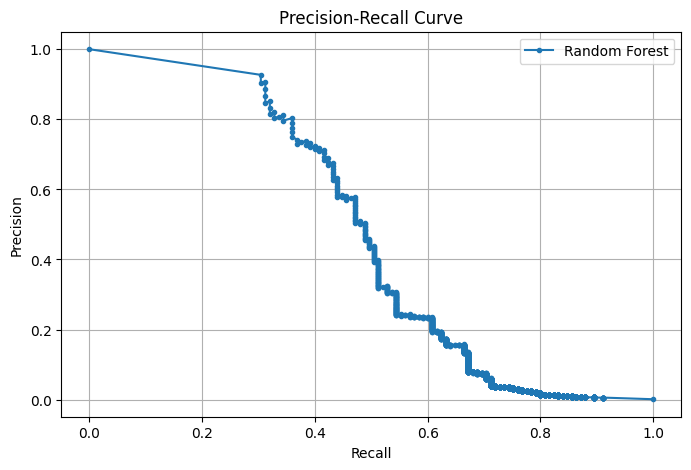

In [ ]:
# === Precision-Recall Curve ===
y_proba_test = best_rf.predict_proba(X_test_pca)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_proba_test)

plt.figure(figsize=(8,5))
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# **Simpan Model**

In [ ]:
from google.colab import files

# setelah rf_model.fit(...)
# Simpan dengan kompresi level 5 (1–9, semakin besar makin tinggi rasio kompresi tapi lebih lambat)
joblib.dump(rf_model, "rf_model_compressed.pkl", compress=5)

['rf_model_compressed.pkl']

In [ ]:
# misal kamu sudah punya nama file di variabel
filename = 'feature_selector.pkl'

# Menyimpan objek feature_selector ke dalam file
joblib.dump(selector, filename)

print(f"Feature selector berhasil disimpan sebagai {filename}")

Feature selector berhasil disimpan sebagai feature_selector.pkl


In [ ]:
# misal kamu sudah punya nama file di variabel
filename = 'pca_transformer.pkl'

# Menyimpan objek feature_selector ke dalam file
joblib.dump(selector, filename)

print(f"Feature selector berhasil disimpan sebagai {filename}")

Feature selector berhasil disimpan sebagai pca_transformer.pkl
